#GRN construction using the scRNAseq dataset with 7 patients

In [12]:
# =============================================================================
# 0.  Imports and paths
# =============================================================================
import os, sys, time, json
import numpy  as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib as mpl
import os, gc, warnings

import scipy.io as sio
from scipy import sparse
import anndata as ad

import celloracle            as co
from   celloracle import motif_analysis as ma

co.__version__

'0.20.0'

In [13]:
# 1) Load your base GRN
base_grn = pd.read_parquet("base_GRN_dataframe.parquet")
print("base GRN shape:", base_grn.shape)
# e.g. (80974, 1098)

base GRN shape: (80974, 1098)


In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Load the union‐of‐DEGs
# ─────────────────────────────────────────────────────────────────────────────
# This is the one‐column file you wrote from R
deg_genes = pd.read_csv("deg_genes.txt", header=None, squeeze=True).tolist()
print(f"Loaded {len(deg_genes)} DEGs")

# ─────────────────────────────────────────────────────────────────────────────
# 2) Reconstruct AnnData from your exports
# ─────────────────────────────────────────────────────────────────────────────
# 2A) Raw counts (MatrixMarket)
counts = sio.mmread("counts.mtx")    # shape: (n_genes, n_cells)
counts = counts.T.tocsr()            # now (n_cells, n_genes)

# 2B) Cell metadata
obs = pd.read_csv("obs.csv", index_col="barcode")

# 2C) Gene metadata
var = pd.read_csv("var.csv")
var.index = var["gene_short_name"].astype(str)

# 2D) Build AnnData
adata = ad.AnnData(X=counts, obs=obs, var=var)
print(f"AnnData before filtering: {adata.shape}")

# ─────────────────────────────────────────────────────────────────────────────
# 3) Subset to DEGs (makes no change if counts.mtx/var.csv were already DEG‐only)
# ─────────────────────────────────────────────────────────────────────────────
keep = [g for g in deg_genes if g in adata.var_names]
adata = adata[:, keep].copy()
print(f"AnnData after DEG filter: {adata.shape}")

# ─────────────────────────────────────────────────────────────────────────────
# 4) Add UMAP embedding
# ─────────────────────────────────────────────────────────────────────────────
umap = pd.read_csv("X_umap.csv", index_col=0)
adata.obsm["X_umap"] = umap.loc[adata.obs_names].values

# ─────────────────────────────────────────────────────────────────────────────
# 5) Add Seurat cluster colours (for any downstream plotting)
# ─────────────────────────────────────────────────────────────────────────────
pal = pd.read_csv("seurat_clusters_colors.csv", index_col="cluster")
adata.uns["seurat_clusters_colors"] = pal["color"].tolist()

# ─────────────────────────────────────────────────────────────────────────────
# 6) (Optional) Cast orig.ident as categorical
# ─────────────────────────────────────────────────────────────────────────────
adata.obs["orig.ident"] = adata.obs["orig.ident"].astype(str).astype("category")

# ─────────────────────────────────────────────────────────────────────────────
print("✅ AnnData reconstruction complete.")


Loaded 3545 DEGs
AnnData before filtering: (37561, 3545)
AnnData after DEG filter: (37561, 3545)
✅ AnnData reconstruction complete.


In [15]:
# in your notebook, before import_anndata_as_raw_count:
print("Available obs columns:")
print(adata.obs.columns.tolist())

print("\nExample unique values for a candidate clustering column:")
print(adata.obs["SCT_snn_res.0.5"].unique()[:10])

print("\nAvailable embeddings:")
print(adata.obsm.keys())

Available obs columns:
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'sonication_status', 'percent.mito', 'percent.ribo', 'percent.hb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.14_709', 'DF.classifications_0.25_0.14_709', 'percent.mt', 'predicted.class.score', 'predicted.class', 'predicted.cluster.score', 'predicted.cluster', 'predicted.subclass.score', 'predicted.subclass', 'predicted.cross_species_cluster.score', 'predicted.cross_species_cluster', 'mapping.score', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'pANN_0.25_0.15_646', 'DF.classifications_0.25_0.15_646', 'pANN_0.25_0.26_510', 'DF.classifications_0.25_0.26_510', 'pANN_0.25_0.09_448', 'DF.classifications_0.25_0.09_448', 'pANN_0.25_0.22_554', 'DF.classifications_0.25_0.22_554', 'pANN_0.25_0.08_552', 'DF.classifications_0.25_0.08_552', 'pANN_0.25_0.02_60

In [16]:
# 1) Instantiate Oracle and import your DEG‐filtered AnnData
oracle = co.Oracle()
oracle.import_anndata_as_raw_count(
    adata               = adata,
    cluster_column_name = "orig.ident",   # Sonicated vs Non-sonicated
    embedding_name      = "X_umap"
)

oracle.import_TF_data(TF_info_matrix=base_grn)


... storing 'patient_id' as categorical
... storing 'sonication_status' as categorical
... storing 'DF.classifications_0.25_0.14_709' as categorical
... storing 'predicted.class' as categorical
... storing 'predicted.cluster' as categorical
... storing 'predicted.subclass' as categorical
... storing 'predicted.cross_species_cluster' as categorical
... storing 'predicted.celltype.l1' as categorical
... storing 'predicted.celltype.l2' as categorical
... storing 'predicted.celltype.l3' as categorical
... storing 'DF.classifications_0.25_0.15_646' as categorical
... storing 'DF.classifications_0.25_0.26_510' as categorical
... storing 'DF.classifications_0.25_0.09_448' as categorical
... storing 'DF.classifications_0.25_0.22_554' as categorical
... storing 'DF.classifications_0.25_0.08_552' as categorical
... storing 'DF.classifications_0.25_0.02_608' as categorical
... storing 'DF.classifications_0.25_0.16_560' as categorical
... storing 'DF.classifications_0.25_0.1_546' as categorical
..

In [17]:
# PCA + KNN
oracle.perform_PCA()
cumvar = np.cumsum(oracle.pca.explained_variance_ratio_)
n_comps = min(50, np.argmax(cumvar > 0.80) + 1)
k       = max(10, int(0.025 * oracle.adata.n_obs))
oracle.knn_imputation(
    n_pca_dims = n_comps,
    k          = k,
    balanced   = True,
    b_sight    = k * 8,
    b_maxl     = k * 4,
    n_jobs     = 4
)

# infer
links = oracle.get_links(
    cluster_name_for_GRN_unit = "orig.ident",
    alpha                     = 10,
    verbose_level             = 0    # silent to avoid flooding
)

# filter & score
links.filter_links(p=0.001, weight="coef_abs", threshold_number=1000)
links.get_network_score()

# Save results
links.to_hdf5("microglia_origident_DEG.celloracle.links")
oracle.to_hdf5("microglia_origident_DEG.celloracle.oracle")

print("✅ Saved:",
      "microglia_origident_DEG.celloracle.links →",
      "microglia_origident_DEG.celloracle.oracle")

✅ Saved: microglia_origident_DEG.celloracle.links → microglia_origident_DEG.celloracle.oracle


In [18]:
import os, glob

print("CWD:", os.getcwd())
print("All files:")
print(os.listdir())

# Look specifically for anything matching the DEG‐based save prefix
print("Matches for ‘microglia_origident_DEG*’:")
print(glob.glob("microglia_origident_DEG*"))


CWD: /gpfs/projects/p30997/python_projects/CellOracle
All files:
['all_peaks.csv', 'microglia_origident.celloracle.oracle', 'base_GRN_dataframe.parquet', '1. preprocessed_data_for_CellOracle.ipynb', 'seurat_clusters_colors.csv', 'Microglia_PHATE.ipynb', '3. GRN construction model.ipynb', 'TF_binding_motifs_2.ipynb', 'X_umap.csv', '.ipynb_checkpoints', 'genomes', 'GRN_construction_sonicated_microglia.ipynb', 'cache', 'all_peaks_archr.csv', 'microglia.h5ad', '2. TF_binding_motifs.ipynb', 'barcodes.tsv', 'microglia_origident.celloracle.links', 'deg_genes.txt', 'gene_activity_archr.csv', 'microglia.celloracle.oracle', 'archr_motif_positions.csv', 'cicero_connections.csv', 'var.csv', 'base_GRN_microglia_dataframe.parquet', 'figures', 'peak2gene_archr_allGenes.csv', 'cicero_connections_archr.csv', 'test1.celloracle.tfinfo', 'microglia_cell_metadata.csv', 'processed_peak_file.csv', 'microglia.celloracle.links', 'microglia_origident_DEG.celloracle.oracle', 'genes.tsv', 'counts.mtx', 'microglia

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import celloracle as co

# ──────────────────────────────────────────────────────────────────────────
# 1) Reload your saved objects
# ──────────────────────────────────────────────────────────────────────────
LINKS_H5  = "microglia_origident_DEG.celloracle.links"
ORACLE_H5 = "microglia_origident_DEG.celloracle.oracle"

links  = co.load_hdf5(LINKS_H5)
oracle = co.load_hdf5(ORACLE_H5)

print("Clusters available:", links.cluster)
# → ['Non-sonicated', 'Sonicated']

# ──────────────────────────────────────────────────────────────────────────
# 2) Edge lists per group
# ──────────────────────────────────────────────────────────────────────────
os.makedirs("figures/edges", exist_ok=True)
for grp in links.cluster:
    df = links.filtered_links[grp]
    print(f"{grp}: {df.shape[0]} edges")
    df.to_csv(f"figures/edges/{grp}_edges.csv", index=True)

# ──────────────────────────────────────────────────────────────────────────
# 3) Combined network‐score table
# ──────────────────────────────────────────────────────────────────────────
merged = links.merged_score   # long format: one row per gene×cluster
merged.to_csv("figures/merged_network_scores.csv")
print("Merged score table saved:", merged.shape)

# ──────────────────────────────────────────────────────────────────────────
# 4) Quick “top influencers” per group (eigenvector centrality)
# ──────────────────────────────────────────────────────────────────────────
for grp in links.cluster:
    df_grp = merged[merged["cluster"] == grp]
    top20  = df_grp.sort_values("eigenvector_centrality", ascending=False).head(20)
    print(f"\nTop 20 influencers in {grp}:")
    print(top20[["eigenvector_centrality"]])



Clusters available: ['Non-sonicated', 'Sonicated']
Non-sonicated: 1000 edges
Sonicated: 1000 edges
Merged score table saved: (750, 9)

Top 20 influencers in Non-sonicated:
        eigenvector_centrality
YY1                   1.000000
FOS                   0.768194
JUND                  0.560714
RPLP1                 0.484854
JUNB                  0.444556
MAF                   0.422165
RPS3A                 0.408083
TCF7L2                0.395589
TMSB4X                0.369323
USF2                  0.361485
RPS6                  0.342421
RPL11                 0.341832
CCL4L2                0.339302
TPT1                  0.333159
RPS16                 0.320440
RPS18                 0.305258
CHD2                  0.290111
RPS28                 0.287493
RPL13                 0.283832
RPL3                  0.273362

Top 20 influencers in Sonicated:
        eigenvector_centrality
FOS                   1.000000
JUND                  0.768853
YY1                   0.644591
JUNB               

<Figure size 640x480 with 0 Axes>

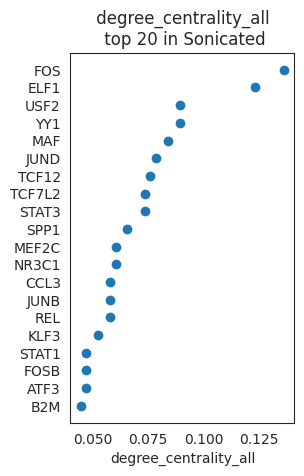

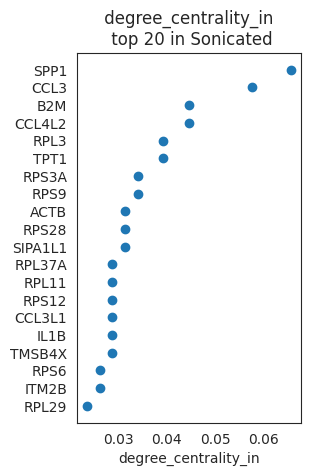

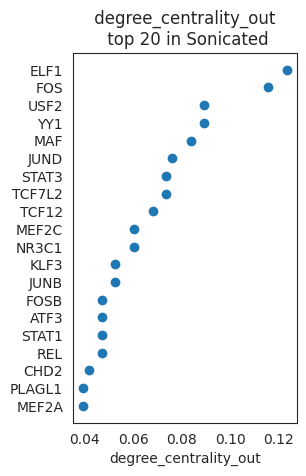

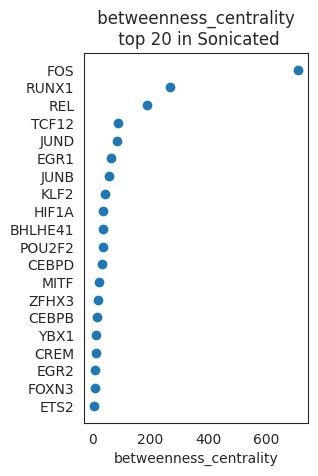

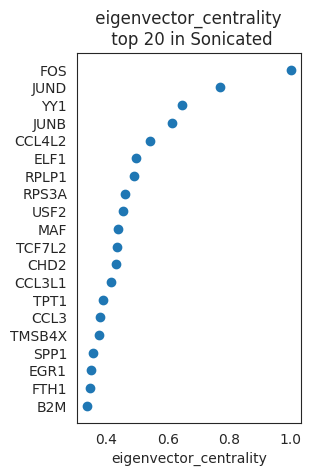

<Figure size 640x480 with 0 Axes>

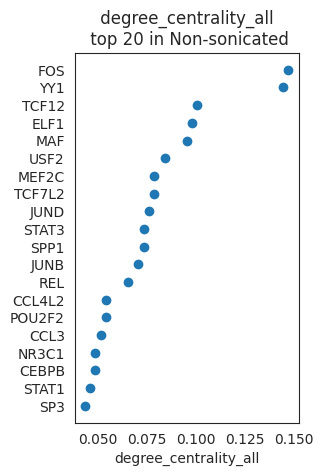

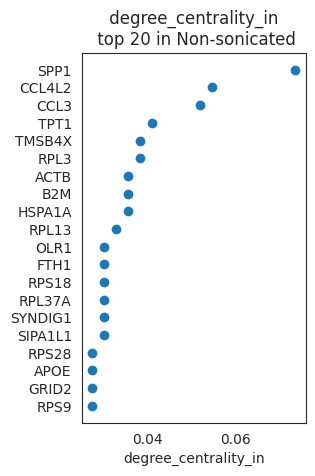

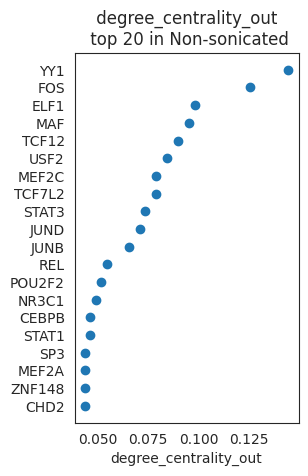

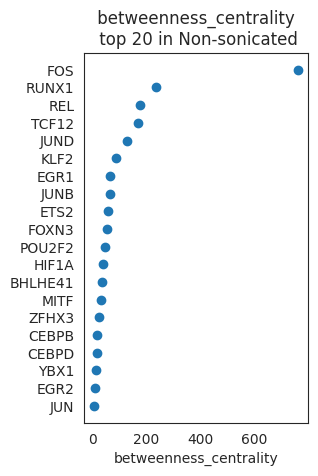

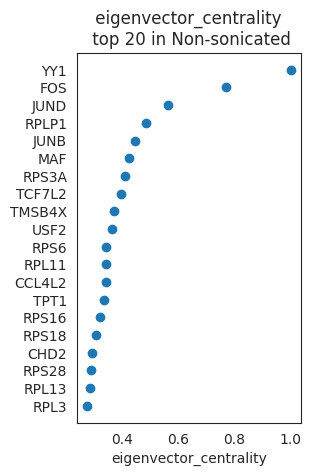

FOS


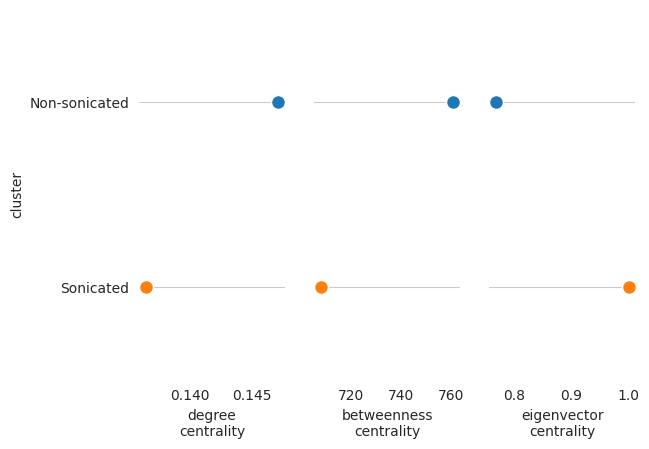

<Figure size 600x450 with 0 Axes>

In [24]:
# ──────────────────────────────────────────────────────────────────────────
# 5) Inline plots (optional)
# ──────────────────────────────────────────────────────────────────────────
%matplotlib inline

# a) Top‐rank plots
plt.figure()
links.plot_scores_as_rank(cluster="Sonicated",     n_gene=20)
plt.show()

plt.figure()
links.plot_scores_as_rank(cluster="Non-sonicated", n_gene=20)
plt.show()

# b) Dynamics of FOS
plt.figure()
links.plot_score_per_cluster(goi="FOS")
plt.show()

# c) Network‐entropy distributions
plt.figure(figsize=(6,4.5))
links.plot_network_entropy_distributions
plt.show()



In [65]:
# look at the first few rows of the Sonicated edge table
tmp = links.filtered_links[links.cluster[0]]   # e.g. 'Sonicated'
print("Columns:", tmp.columns.tolist())
print("Index  :", tmp.index.names)
print(tmp.head())

# list all the available network‐score metrics
metrics = links.merged_score.columns.drop("cluster").tolist()
print("Available metrics:\n", metrics)


Columns: ['source', 'target', 'coef_mean', 'coef_abs', 'p', '-logp']
Index  : [None]
      source  target  coef_mean  coef_abs             p      -logp
83831    YY1   RPLP1   1.044152  1.044152  8.205090e-13  12.085917
1149   GTF2I    ACTB   0.929592  0.929592  5.882804e-12  11.230416
83829   CHD2   RPLP1  -0.881017  0.881017  3.220305e-10   9.492103
82718    YY1   RPL11   0.867730  0.867730  1.032197e-14  13.986238
14951   CHD2  CCL3L1   0.862887  0.862887  2.393263e-08   7.621010
Available metrics:
 ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']


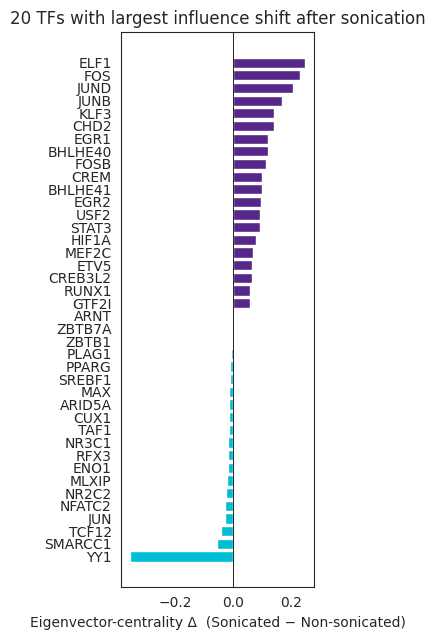

In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams["font.family"]     = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]

# ensure output directory
os.makedirs("figures", exist_ok=True)

# 1) Collect TF symbols
tf_set = {
    src
    for grp in links.cluster
    for src in links.filtered_links[grp]["source"].unique()
}

# 2) Build Δ eigenvector-centrality table
metric      = "eigenvector_centrality"
merged_long = links.merged_score

tf_merged = merged_long.loc[merged_long.index.isin(tf_set)].copy()

wide = (
    tf_merged
    .reset_index()
    .pivot(index="index", columns="cluster", values=metric)
    .rename_axis(index="gene")
)
wide["delta"] = wide["Sonicated"] - wide["Non-sonicated"]

# 3) Select & order top N
N   = 20
up   = wide.nlargest(N, "delta").sort_values("delta", ascending=False)
down = wide.nsmallest(N, "delta").sort_values("delta", ascending=False)
plot_df = pd.concat([up, down])
plot_df["color"] = plot_df["delta"].gt(0).map({True: "#542788", False: "#00BCD4"})

# 4) Plot
fig, ax = plt.subplots(figsize=(3, 6.5))
ax.barh(plot_df.index, plot_df["delta"], color=plot_df["color"])
ax.axvline(0, color="black", lw=0.6)
ax.set_xlabel("Eigenvector-centrality Δ  (Sonicated − Non-sonicated)")
ax.set_title(f"{N} TFs with largest influence shift after sonication")
ax.invert_yaxis()
plt.tight_layout()

plt.show()



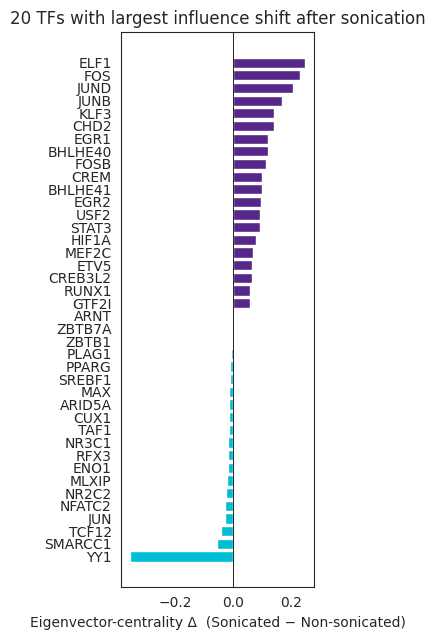

In [72]:
#USING THIS FOR THE FIGURE
import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output directory
os.makedirs("figures", exist_ok=True)

# 1) Collect TF symbols
tf_set = {
    src
    for grp in links.cluster
    for src in links.filtered_links[grp]["source"].unique()
}

# 2) Build Δ eigenvector-centrality table
metric      = "eigenvector_centrality"
merged_long = links.merged_score

tf_merged = merged_long.loc[merged_long.index.isin(tf_set)].copy()

wide = (
    tf_merged
    .reset_index()
    .pivot(index="index", columns="cluster", values=metric)
    .rename_axis(index="gene")
)
wide["delta"] = wide["Sonicated"] - wide["Non-sonicated"]

# 3) Select & order top N
N   = 20
up   = wide.nlargest(N, "delta").sort_values("delta", ascending=False)
down = wide.nsmallest(N, "delta").sort_values("delta", ascending=False)
plot_df = pd.concat([up, down])
plot_df["color"] = plot_df["delta"].gt(0).map({True: "#542788", False: "#00BCD4"})

# 4) Plot
fig, ax = plt.subplots(figsize=(3, 6.5))
ax.barh(plot_df.index, plot_df["delta"], color=plot_df["color"])
ax.axvline(0, color="black", lw=0.6)
ax.set_xlabel("Eigenvector-centrality Δ  (Sonicated − Non-sonicated)")
ax.set_title(f"{N} TFs with largest influence shift after sonication")
ax.invert_yaxis()
plt.tight_layout()

# 5) Save figure
fig.savefig("figures/TF_delta_eigenvector_centrality_shift_scRNAseq.svg", bbox_inches="tight")
fig.savefig("figures/TF_delta_eigenvector_centrality_shift_scRNAseq.png", dpi=400, bbox_inches="tight")

# 6) Show
plt.show()


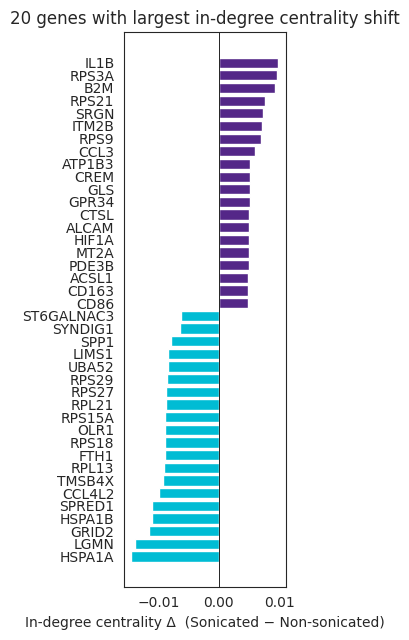

In [73]:
#USING THIS FOR THE FIGURE
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ─── Set DejaVu Sans font ────────────────────────────────────────────────
mpl.rcParams["font.family"]     = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]

# ─── Ensure output directory ────────────────────────────────────────────
os.makedirs("figures", exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────
# 1) Build Δ in-degree centrality table for **all** nodes
# ──────────────────────────────────────────────────────────────────────────
metric      = "degree_centrality_in"
merged_long = links.merged_score   # one row per gene × cluster

# pivot to wide: rows=gene, cols=cluster
wide = (
    merged_long
    .reset_index()
    .pivot(index="index", columns="cluster", values=metric)
    .rename_axis(index="gene")
)
wide["delta"] = wide["Sonicated"] - wide["Non-sonicated"]

# ──────────────────────────────────────────────────────────────────────────
# 2) Select & order top N gains and losses
# ──────────────────────────────────────────────────────────────────────────
N   = 20
up   = wide.nlargest (N, "delta").sort_values("delta", ascending=False)  # biggest ↑Sonicated
down = wide.nsmallest(N, "delta").sort_values("delta", ascending=False)  # smallest (closest to 0) first

plot_df = pd.concat([up, down])
plot_df["color"] = plot_df["delta"].gt(0).map({True: "#542788", False: "#00BCD4"})

# ──────────────────────────────────────────────────────────────────────────
# 3) Plot
# ──────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(3, 6.5))
ax.barh(plot_df.index, plot_df["delta"], color=plot_df["color"])
ax.axvline(0, color="black", lw=0.6)

ax.set_xlabel("In-degree centrality Δ  (Sonicated − Non-sonicated)")
ax.set_title(f"{N} genes with largest in-degree centrality shift")

# flip so the biggest Sonicated-up genes are at the top
ax.invert_yaxis()
plt.tight_layout()

# 5) Save figure
fig.savefig("figures/TF_delta_in_degree_centrality_shift_scRNAseq.svg", bbox_inches="tight")
fig.savefig("figures/TF_delta_in_degree_centrality_shift_scRNAseq.png", dpi=400, bbox_inches="tight")

plt.show()